<a href="https://colab.research.google.com/github/sachin5nowal/ECG-Heartbeat-classification/blob/main/ECG_Heartbeat_classification_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install -qq arff2pandas

In [ ]:
!pip install -q -U watermark

In [ ]:
from tensorflow.keras.layers import LSTM,Dropout,RepeatVector,TimeDistributed,Dense
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import Input
from tensorflow.keras.layers import MaxPool1D,GlobalAveragePooling1D
from arff2pandas import a2p
%matplotlib inline


RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_folder_path="/content/drive/My Drive/drive_datasets/ecg_anomaly/ECG5000"

In [ ]:
with open(data_folder_path+'/ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open(data_folder_path+'/ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [ ]:
df = train.append(test)
df = df.sample(frac=1.0)
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.

In [ ]:
class_dict={'Normal':1,'R on T': 2, 'PVC': 3, 'SP': 4, 'UB':5}
class_names = ['Normal','R on T','PVC','SP','UB']

In [ ]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [ ]:
df=df.astype(float)
df['target']=df.target.astype(int)

In [ ]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

In [ ]:
df.reset_index(drop=True,inplace=True)
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
0,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
1,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
3,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.116396,-0.230415,-0.12699

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.15, random_state = RANDOM_SEED ,stratify = df['target'])
# X_test_df, X_val_df, y_test_df, y_val_df = train_test_split(X_val_df, y_val_df, test_size = 0.33, random_state = RANDOM_SEED ,stratify = y_val_df)

In [ ]:
(df_train.target.value_counts(),df_test.target.value_counts())

(1    2481
 2    1502
 4     165
 3      82
 5      20
 Name: target, dtype: int64, 1    438
 2    265
 4     29
 3     14
 5      4
 Name: target, dtype: int64)

In [ ]:
df_test=df_test.reset_index(drop=True)
df_train.reset_index(inplace=True,drop=True)

In [ ]:
def resample_df(df_n,n_samples):
  df_size=df_n.shape[0]
  print("df_size",df_size,"  n_samples:",n_samples)
  if(n_samples>df_size):
    idx_array=np.random.randint(low=0,high=df_size,size=n_samples-df_size)
    for idx in idx_array:
      df_row=df_n[idx:+idx+1]
      df_n=df_n.append(df_row)
  else:
    df_n=df_n[:n_samples]

  df_n.reset_index(drop=True,inplace=True)
  return df_n

In [ ]:
from sklearn.utils import resample

df_1=df_train[df_train['target']==1]
df_2=df_train[df_train['target']==2]
df_3=df_train[df_train['target']==3]
df_4=df_train[df_train['target']==4]
df_5=df_train[df_train['target']==5]

df_1_upsample=resample_df(df_1,n_samples=3000)
df_2_upsample=resample_df(df_2,n_samples=3000)
df_3_upsample=resample_df(df_3,n_samples=3000)
df_4_upsample=resample_df(df_4,n_samples=3000)
df_5_upsample=resample_df(df_5,n_samples=3000)



df_train=pd.concat([df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])

df_size 2481   n_samples: 3000
df_size 1502   n_samples: 3000
df_size 82   n_samples: 3000
df_size 165   n_samples: 3000
df_size 20   n_samples: 3000


In [ ]:
#Creating dataset
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
0,0.428189,0.247690,0.593090,0.392702,0.731773,0.749147,1.082965,1.353267,1.503086,1.764223,1.899895,2.069327,2.390867,2.433236,2.160356,1.844264,1.357969,0.906488,0.667051,0.844574,1.281899,0.944528,0.058076,-1.013971,-2.313765,-3.201600,-3.542485,-3.631665,-3.587112,-3.452215,-3.170108,-2.584844,-1.829318,-1.347474,-1.203070,-0.938070,-0.487234,-0.127294,0.072942,0.157459,...,0.173720,0.068657,0.146417,0.159153,0.068987,0.038929,0.020798,0.045269,0.051147,-0.004422,-0.047452,-0.053370,-0.123159,-0.141331,-0.055308,-0.064201,-0.075217,-0.093524,-0.165395,-0.135054,-0.100177,-0.087576,-0.022191,-0.054880,-0.012283,0.010006,-0.024228,0.108436,0.063253,0.080791,0.119756,0.177637,0.200501,0.154375,0.270318,0.165414,0.524893,-0.036427,0.747056,5
1,0.559025,-0.250009,-1.186557,-1.926781,-2.512148,-3.380124,-3.673658,-3.321318,-2.582966,-1.865770,-1.179856,-0.963753,-1.070368,-0.691207,-0.276343,-0.090566,0.107235,0.172821,0.066329,-0.144837,-0.193229,-0.299536,-0.237467,-0.124652,-0.192765,-0.152412,-0.250319,-0.106074,-0.158651,-0.230230,-0.137910,-0.060665,-0.012024,-0.046506,-0.013098,-0.453678,-0.414015,-0.285922,-0.353343,-0.384381,...,0.444395,0.418153,0.495842,0.634417,0.700332,0.561835,0.558870,0.515507,0.569509,0.646615,0.776936,0.947254,0.772989,0.697242,0.801582,0.882871,1.043275,0.988903,0.876786,0.800267,0.818393,0.804377,0.948291,1.012224,1.001772,1.368134,1.780870,2.135728,2.026921,1.735634,1.505515,1.320216,1.576958,2.303481,2.787780,2.395158,1.832473,1.312199,1.526439,4
2,0.173818,-0.053025,-0.573232,-1.081395,-1.281882,-1.699047,-1.820882,-1.584040,-1.243384,-0.883937,-0.772693,-0.685925,-0.309587,-0.150860,-0.153912,-0.162291,-0.173245,-0.126827,-0.160479,-0.108718,-0.095384,-0.113283,-0.142442,-0.120138,-0.127322,-0.183334,-0.168763,-0.223837,-0.137388,-0.150590,-0.185033,-0.192394,-0.166914,-0.201185,-0.234467,-0.228371,-0.306717,-0.295965,-0.345558,-0.302862,...,0.315906,0.265162,0.284264,0.297159,0.232129,0.290982,0.337098,0.360384,0.418840,0.563825,0.664673,0.831881,0.991968,1.048374,1.072274,1.224914,1.469286,1.638238,1.753155,1.985394,2.256961,2.432691,2.686662,2.894476,2.878173,2.645280,2.147916,1.878903,1.192704,0.382517,-0.043067,-0.174137,-0.808445,-2.292176,-3.068600,-3.353893,-3.364641,-2.650505,-1.818790,3
3,0.385640,-0.105185,-0.433158,-0.744981,-0.941007,-1.372430,-1.670710,-1.635797,-1.565886,-1.439333,-1.197219,-0.857004,-0.508721,-0.346176,-0.333931,-0.173900,0.129442,0.287337,0.305418,0.336742,0.312526,0.206623,0.225137,0.372065,0.406844,0.354906,0.356437,0.371509,0.358255,0.316013,0.273542,0.314567,0.375599,0.341348,0.334078,0.401253,0.399593,0.366549,0.379028,0.385705,...,0.801216,0.811269,0.752193,0.649676,0.588601,0.677641,0.775510,0.793440,0.772655,0.746009,0.758826,0.750921,0.699926,0.585293,0.447345,0.462163,0.463393,0.350768,0.264683,0.090573,-0.120455,-0.3182

In [ ]:
def transpose_func(X,y):
  X=tf.transpose(X)
  return X,y

def one_hot_y(num):
  if(num>=1 and num<=5):
    num_lis=[0,0,0,0,0]
    num_lis[num-1]=1
    return num_lis
  else:
    # print("Error")
    ValueError("Error")

def create_dataset(df):
  X=df.drop(['target'],axis=1)
  y=pd.DataFrame({'target':df['target']})

  X_dataset=[[list(row[1])] for row in X.iterrows()]
  n_features=len(X_dataset[0])
  y_dataset=[one_hot_y(int(val)) for val in y['target']]

  dataset = tf.data.Dataset.from_tensor_slices((X_dataset,y_dataset))
  dataset=dataset.map(transpose_func)
  dataset=dataset.batch(8, drop_remainder=True)
  return dataset

In [ ]:
dataset_train=create_dataset(df_train)
dataset_test=create_dataset(df_test)

In [ ]:
model = Sequential()
model.add(Input(shape=(140,1)))
model.add(Conv1D(100, 10, activation='relu', input_shape=(140, 1)))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPool1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 131, 100)          1100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 100)          100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31, 160)           160160    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 160)           256160    
_________________________________________________________________
global_average_pooling1d (Gl (None, 160)               0         
_________________________________________________________________
dropout (Dropout)            (None, 160)               0

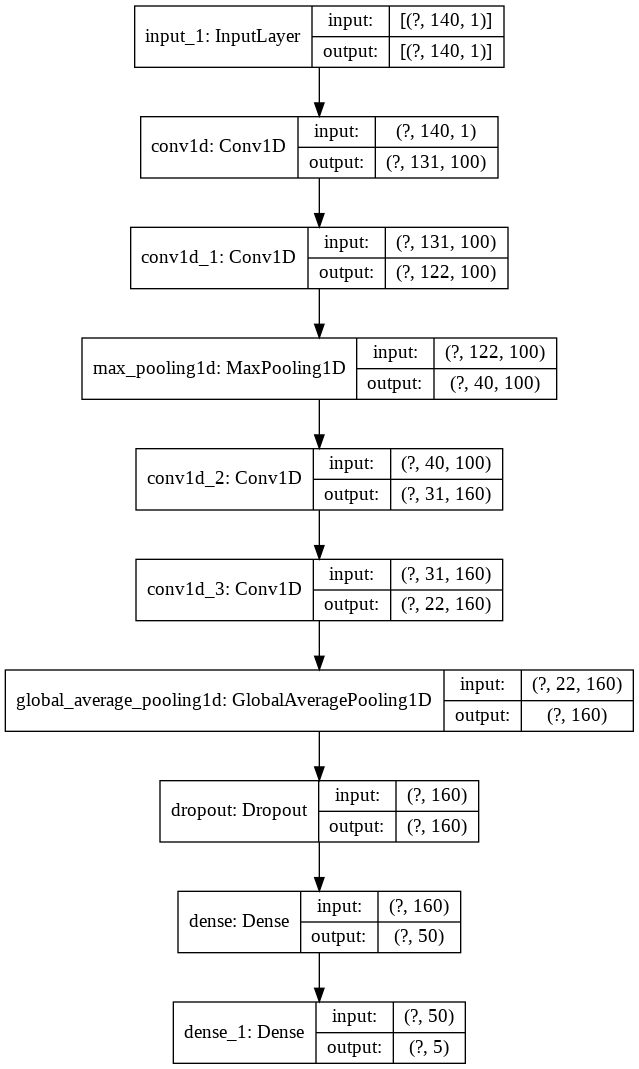

In [ ]:
plot_model(model, 'my_first_model.png',show_shapes=True)

In [ ]:
history=model.fit(dataset_train,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.7227 - accuracy: 0.7020
Epoch 2/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.3288 - accuracy: 0.8615
Epoch 3/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.2366 - accuracy: 0.8981
Epoch 4/10
1875/1875 [==============================] - 76s 40ms/step - loss: 0.1946 - accuracy: 0.9163
Epoch 5/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.1586 - accuracy: 0.9351
Epoch 6/10
1875/1875 [==============================] - 76s 41ms/step - loss: 0.1176 - accuracy: 0.9538
Epoch 7/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0975 - accuracy: 0.9673
Epoch 8/10
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0797 - accuracy: 0.9732
Epoch 9/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0552 - accuracy: 0.9827
Epoch 10/10
1875/1875 [==============================] - 76s 40m

In [ ]:
pred=model.predict(dataset_test)
y_pred=np.argmax(pred,axis=-1)+1

In [ ]:
y_pred=np.argmax(pred,axis=-1)+1


In [ ]:
print(classification_report(y_pred,df_test['target'][:744],target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       431
      R on T       0.95      0.91      0.93       276
         PVC       0.46      0.40      0.43        15
          SP       0.38      0.58      0.46        19
          UB       0.25      0.33      0.29         3

    accuracy                           0.94       744
   macro avg       0.61      0.64      0.62       744
weighted avg       0.95      0.94      0.94       744



In [ ]:
# WARNING:tensorflow:From <ipython-input-55-634cb3625748>:1: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
# Instructions for updating:
# Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).